# Compare Feature Selection Methods and Identify Overlapping Features
### Group 33, Florida Atlantic University
- Compare top-ranked features from Fold-Change, Chi-Squared, Information Gain, and Lasso.
- Identify overlapping features across different methods to find consistently important biomarkers.
- Save results for biomarker ranking and downstream analysis.


> Load Feature Selection Results

In [64]:
import pandas as pd
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define the directory containing results
RESULTS_DIR = "../results"

# Define file paths exactly as in your folder
file_paths = {
    "fold_change": os.path.join(RESULTS_DIR, "fold_change_results.csv"),
    "chi2": os.path.join(RESULTS_DIR, "chi_squared_features.csv"),
    "info_gain": os.path.join(RESULTS_DIR, "information_gain_results.csv"),
    "lasso": os.path.join(RESULTS_DIR, "lasso_results.csv"),
    "rfe": os.path.join(RESULTS_DIR, "recursive_feature_elimination", "recursive_feature_selection_general.csv"),
    "nca": os.path.join(RESULTS_DIR, "nca_results.csv"),
}

# Load available feature selection results
feature_sets = {}

# Define expected feature column names for each method
required_columns = {
    "fold_change": "Unnamed: 0",
    "chi2": "Feature",
    "info_gain": "Feature",
    "lasso": "Feature",
    "rfe": "Feature",
    "nca": "Feature",
}

for method, path in file_paths.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        
        # Check if required column exists
        if required_columns[method] not in df.columns:
            logging.error(f"Missing expected column '{required_columns[method]}' in {path}. Skipping {method}.")
            continue

        # Store as set
        feature_sets[method] = set(df[required_columns[method]].drop_duplicates())

        logging.info(f"Loaded {method} features: {len(feature_sets[method])} features.")
    else:
        logging.warning(f"Missing file: {path}. Skipping {method}.")

print("Feature sets loaded successfully!")

# Define variables for visualization with fallback to avoid crashes
fold_change_features = feature_sets.get("fold_change", set())
chi2_features = feature_sets.get("chi2", set())
info_gain_features = feature_sets.get("info_gain", set())
lasso_features = feature_sets.get("lasso", set())
rfe_features = feature_sets.get("rfe", set())
nca_features = feature_sets.get("nca", set())

print("\nFeature counts:")
print(f"Fold change features: {len(fold_change_features)}")
print(f"Chi-squared features: {len(chi2_features)}")
print(f"Information gain features: {len(info_gain_features)}")
print(f"LASSO features: {len(lasso_features)}")
print(f"RFE features: {len(rfe_features)}")
print(f"NCA features: {len(nca_features)}")

2025-02-08 14:34:01,164 - INFO - Loaded fold_change features: 1882 features.
2025-02-08 14:34:01,168 - INFO - Loaded chi2 features: 1637 features.
2025-02-08 14:34:01,172 - INFO - Loaded info_gain features: 1881 features.
2025-02-08 14:34:01,175 - INFO - Loaded lasso features: 503 features.
2025-02-08 14:34:01,178 - INFO - Loaded rfe features: 50 features.
2025-02-08 14:34:01,181 - INFO - Loaded nca features: 26 features.


Feature sets loaded successfully!

Feature counts:
Fold change features: 1882
Chi-squared features: 1637
Information gain features: 1881
LASSO features: 503
RFE features: 50
NCA features: 26


> Feature Inspection & Overlap Calculation

In [65]:
import logging

print("\nFeature name examples from each method:")
for method, features in feature_sets.items():
    print(f"\n{method} (first 5):")
    features_list = list(features)
    print(features_list[:5])  # Show first 5 features

print("\nFeature format check:")
for method, features in feature_sets.items():
    if features:  # Ensure features exist before accessing
        feature = list(features)[0]  # Get first feature
        print(f"{method}: {feature} (type: {type(feature)})")
    else:
        print(f"{method}: No features found.")

# Check for exact overlaps dynamically, preventing redundant comparisons
method_keys = sorted(feature_sets.keys())  # Sort for consistent order

for i in range(len(method_keys)):
    for j in range(i + 1, len(method_keys)):  # Prevents duplicate comparisons
        method1, method2 = method_keys[i], method_keys[j]
        overlap = len(feature_sets[method1] & feature_sets[method2])
        print(f"\nOverlap between {method1} and {method2}: {overlap} features")


Feature name examples from each method:

fold_change (first 5):
['hsa-mir-1296', 'hsa-mir-4518', 'hsa-mir-3675', 'hsa-mir-3159', 'hsa-mir-483']

chi2 (first 5):
['hsa-mir-1296', 'hsa-mir-3675', 'hsa-mir-4518', 'hsa-mir-3159', 'hsa-mir-483']

info_gain (first 5):
['hsa-mir-1296', 'hsa-mir-4518', 'hsa-mir-3675', 'hsa-mir-3159', 'hsa-mir-483']

lasso (first 5):
['hsa-mir-3675', 'hsa-mir-4518', 'hsa-mir-3159', 'hsa-mir-4709', 'hsa-mir-219a-1']

rfe (first 5):
['hsa-mir-4284', 'hsa-mir-19a', 'hsa-mir-3907', 'hsa-mir-4434', 'hsa-mir-425']

nca (first 5):
['hsa-mir-3617', 'hsa-mir-4642', 'hsa-mir-4739', 'hsa-mir-6835', 'hsa-mir-4703']

Feature format check:
fold_change: hsa-mir-1296 (type: <class 'str'>)
chi2: hsa-mir-1296 (type: <class 'str'>)
info_gain: hsa-mir-1296 (type: <class 'str'>)
lasso: hsa-mir-3675 (type: <class 'str'>)
rfe: hsa-mir-4284 (type: <class 'str'>)
nca: hsa-mir-3617 (type: <class 'str'>)

Overlap between chi2 and fold_change: 1636 features

Overlap between chi2 and info

> Find Overlapping Features

In [66]:
# Ensure all feature sets exist before computing intersections
available_methods = [m for m in ["fold_change", "chi2", "info_gain", "lasso", "rfe", "nca"] if m in feature_sets]

# Compute pairwise overlaps instead of full intersection
overlap_dict = {}

for i in range(len(available_methods)):
    for j in range(i + 1, len(available_methods)):  # Avoid duplicate comparisons
        method1, method2 = available_methods[i], available_methods[j]
        overlap_set = feature_sets[method1] & feature_sets[method2]
        
        if len(overlap_set) > 0:  # Only store meaningful overlaps
            overlap_dict[f"{method1} & {method2}"] = overlap_set

# Print overlap statistics
print(f"\nPairwise Feature Overlaps:")
for key, value in overlap_dict.items():
    print(f"{key}: {len(value)} features")

# Find features appearing in at least **3 different methods**
from collections import Counter

# Count how many times each feature appears
feature_counter = Counter()
for feature_set in feature_sets.values():
    feature_counter.update(feature_set)

# Keep only features that appear in at least 3 methods
overlapping_features = {feature for feature, count in feature_counter.items() if count >= 3}

# Display final results
print(f"\nFeatures appearing in at least 3 methods: {len(overlapping_features)}")
print("Sample overlapping features:", list(overlapping_features)[:5])

# Save results
overlap_df = pd.DataFrame({'Feature': list(overlapping_features)})
overlap_df.to_csv('../results/overlapping_features.csv', index=False)
print("Overlapping features saved successfully!")


Pairwise Feature Overlaps:
fold_change & chi2: 1636 features
fold_change & info_gain: 1881 features
fold_change & lasso: 503 features
fold_change & rfe: 50 features
fold_change & nca: 26 features
chi2 & info_gain: 1636 features
chi2 & lasso: 503 features
chi2 & rfe: 50 features
chi2 & nca: 26 features
info_gain & lasso: 503 features
info_gain & rfe: 50 features
info_gain & nca: 26 features
lasso & rfe: 21 features
lasso & nca: 7 features

Features appearing in at least 3 methods: 1636
Sample overlapping features: ['hsa-mir-1296', 'hsa-mir-4518', 'hsa-mir-3675', 'hsa-mir-3159', 'hsa-mir-483']
Overlapping features saved successfully!


> Filtering Processed Data for Overlapping Features

In [67]:
import pandas as pd
import numpy as np
import logging

# Load processed data containing miRNA expression values and target variables
processed_data_path = '../processed_data/miRNA_stage_subtype.csv'
processed_data = pd.read_csv(processed_data_path)

# Ensure overlapping features exist before proceeding
if not overlapping_features:
    raise ValueError("No overlapping features found! Check feature selection methods.")

# Convert overlapping features to list for indexing
overlapping_feature_list = list(overlapping_features)

# Print distribution of target variable before filtering
print("\nTarget variable (stage) distribution before filtering:")
print(processed_data['stage'].value_counts())

# Ensure the dataset contains the required overlapping features
missing_features = [feature for feature in overlapping_feature_list if feature not in processed_data.columns]
if missing_features:
    logging.warning(f"Some overlapping features are missing in the dataset: {missing_features}")

# Filter processed data for only the overlapping features
expression_values = processed_data[overlapping_feature_list]
y = processed_data['stage']

# Basic statistics before handling missing values
print("\nDataset statistics before handling missing values:")
print(f"Total samples: {len(processed_data)}")
print(f"Number of features: {len(overlapping_feature_list)}")
print(f"Features with missing values: {expression_values.isnull().any().sum()}")
print(f"Samples with missing values: {expression_values.isnull().any(axis=1).sum()}")

# Check for missing values in features or labels
if expression_values.isnull().values.any() or y.isnull().values.any():
    logging.warning("Missing values detected in features or labels.")
    print("\nMissing values per feature (top 5):")
    missing_counts = expression_values.isnull().sum()
    print(missing_counts[missing_counts > 0].head())
    print(f"\nMissing values in labels: {y.isnull().sum()}")

    # Handle missing values: Drop rows with NaN values
    valid_indices = ~expression_values.isnull().any(axis=1) & ~y.isnull()
    expression_values = expression_values[valid_indices]
    y = y[valid_indices]

# Validate dataset shapes after filtering
print("\nFinal dataset dimensions:")
print(f"Expression values shape: {expression_values.shape}")
print(f"Target labels shape: {y.shape}")

# Show class distribution after filtering
print("\nTarget variable distribution after filtering:")
print(y.value_counts())

# Basic statistics of expression values
print("\nExpression values summary statistics:")
print(expression_values.describe())

# Check feature correlation to identify highly correlated features
print("\nHighly correlated features (correlation > 0.9):")
corr_matrix = expression_values.corr()
high_corr = np.where(np.abs(corr_matrix) > 0.9)

# Identify and display correlated feature pairs (avoid duplicate pairs)
high_corr_pairs = [(overlapping_feature_list[i], overlapping_feature_list[j], corr_matrix.iloc[i, j])
                   for i, j in zip(*high_corr) if i < j]

for feat1, feat2, corr in high_corr_pairs[:5]:  # Show top 5 highly correlated feature pairs
    print(f"{feat1} - {feat2}: {corr:.3f}")


Target variable (stage) distribution before filtering:
stage
1    566
2    308
3    175
4     31
0     11
Name: count, dtype: int64

Dataset statistics before handling missing values:
Total samples: 1091
Number of features: 1636
Features with missing values: 0
Samples with missing values: 0

Final dataset dimensions:
Expression values shape: (1091, 1636)
Target labels shape: (1091,)

Target variable distribution after filtering:
stage
1    566
2    308
3    175
4     31
0     11
Name: count, dtype: int64

Expression values summary statistics:
       hsa-mir-1296  hsa-mir-4518  hsa-mir-3675  hsa-mir-3159  hsa-mir-483  \
count   1091.000000   1091.000000   1091.000000   1091.000000  1091.000000   
mean       6.868820      0.007700      0.008876      0.027909     8.711290   
std       14.139539      0.064453      0.066166      0.103619    77.994807   
min        0.000000      0.000000      0.000000      0.000000     0.000000   
25%        2.395231      0.000000      0.000000      0.00000

> Venn Diagram for Feature Overlaps

Global Feature Overlap (UpSet plot) saved to ../results/venn_diagrams\global_feature_overlap_upset.png


<Figure size 1200x800 with 0 Axes>

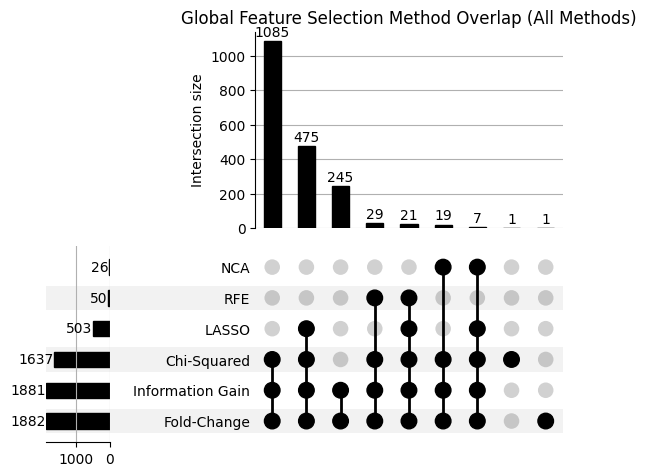

Pairwise overlap matrix saved to ../results/venn_diagrams\pairwise_overlap_matrix.png


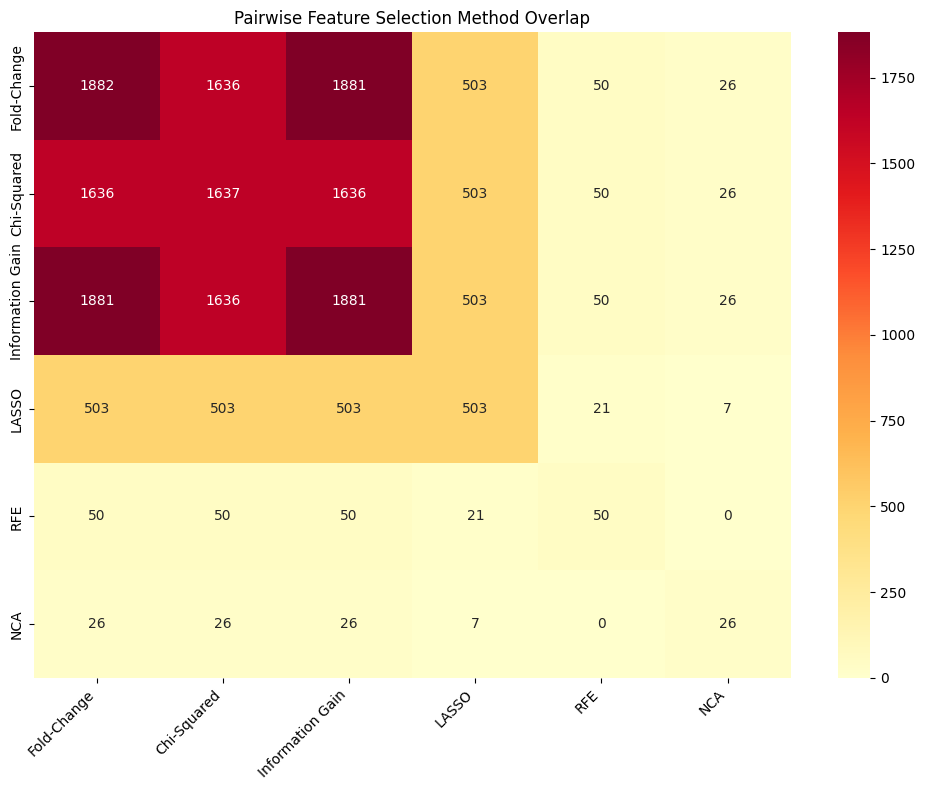

First Venn Diagram saved to ../results/venn_diagrams\global_feature_overlap_venn1.png


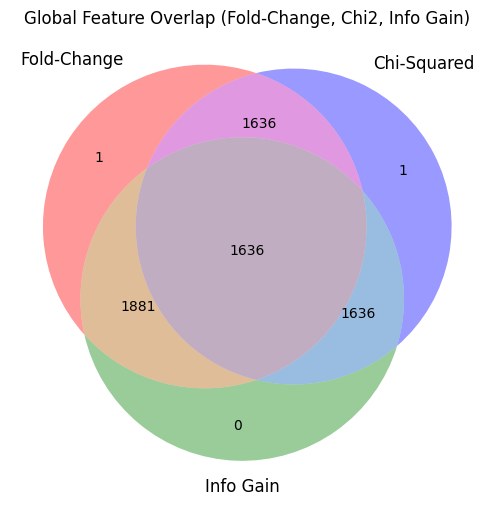

Second Venn Diagram saved to ../results/venn_diagrams\feature_overlap_fc_rfe_nca.png


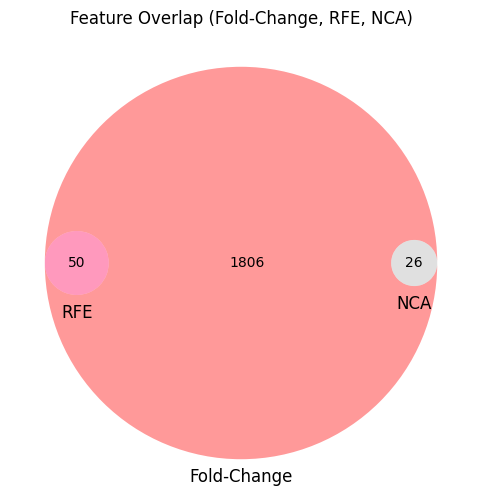

In [68]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from upsetplot import plot
import pandas as pd
import os
import numpy as np
import seaborn as sns
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Ensure output directory exists
output_dir = "../results/venn_diagrams"
os.makedirs(output_dir, exist_ok=True)

# Define feature sets
venn_sets = {
    "Fold-Change": feature_sets.get("fold_change", set()),
    "Chi-Squared": feature_sets.get("chi2", set()),
    "Information Gain": feature_sets.get("info_gain", set()),
    "LASSO": feature_sets.get("lasso", set()),
    "RFE": feature_sets.get("rfe", set()),
    "NCA": feature_sets.get("nca", set())
}

#1. UpSet Plot for All Feature Selection Methods**
all_features = set.union(*venn_sets.values())
data = []
for feature in all_features:
    row = {method: int(feature in features) for method, features in venn_sets.items()}
    data.append(row)

df = pd.DataFrame(data)
combinations = df.value_counts()

plt.figure(figsize=(12, 8))
plot(combinations, sort_by='cardinality', show_counts=True)
plt.title("Global Feature Selection Method Overlap (All Methods)")

#Save UpSet plot
upset_path = os.path.join(output_dir, "global_feature_overlap_upset.png")
plt.savefig(upset_path, bbox_inches='tight', dpi=300)
print(f"Global Feature Overlap (UpSet plot) saved to {upset_path}")
plt.show()

#2. Pairwise Overlap Heatmap**
plt.figure(figsize=(10, 8))
methods = list(venn_sets.keys())
overlap_matrix = np.zeros((len(methods), len(methods)))

for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        overlap_matrix[i, j] = len(venn_sets[method1] & venn_sets[method2])

#Heatmap Plot
sns.heatmap(overlap_matrix, xticklabels=methods, yticklabels=methods, annot=True, fmt='g', cmap='YlOrRd')
plt.title("Pairwise Feature Selection Method Overlap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#Save Heatmap
heatmap_path = os.path.join(output_dir, "pairwise_overlap_matrix.png")
plt.savefig(heatmap_path, bbox_inches='tight', dpi=300)
print(f"Pairwise overlap matrix saved to {heatmap_path}")
plt.show()

#3. Venn Diagram - Fold-Change, Chi-Squared, Info Gain**
overlap_fc_chi2 = len(venn_sets["Fold-Change"] & venn_sets["Chi-Squared"])
overlap_fc_info = len(venn_sets["Fold-Change"] & venn_sets["Information Gain"])
overlap_chi2_info = len(venn_sets["Chi-Squared"] & venn_sets["Information Gain"])
overlap_all_three = len(venn_sets["Fold-Change"] & venn_sets["Chi-Squared"] & venn_sets["Information Gain"])

plt.figure(figsize=(7, 6))
venn3(
    subsets=(len(venn_sets["Fold-Change"]) - overlap_fc_chi2 - overlap_fc_info + overlap_all_three,  # Only Fold-Change
             len(venn_sets["Chi-Squared"]) - overlap_fc_chi2 - overlap_chi2_info + overlap_all_three,  # Only Chi-Squared
             overlap_fc_chi2,  # Fold-Change ∩ Chi-Squared
             len(venn_sets["Information Gain"]) - overlap_fc_info - overlap_chi2_info + overlap_all_three,  # Only Info-Gain
             overlap_fc_info,  # Fold-Change ∩ Info-Gain
             overlap_chi2_info,  # Chi-Squared ∩ Info-Gain
             overlap_all_three),  # All three
    set_labels=("Fold-Change", "Chi-Squared", "Info Gain"),
    set_colors=('red', 'blue', 'green')
)
plt.title("Global Feature Overlap (Fold-Change, Chi2, Info Gain)")

#Save First Venn Diagram
venn1_path = os.path.join(output_dir, "global_feature_overlap_venn1.png")
plt.savefig(venn1_path, bbox_inches='tight', dpi=300)
print(f"First Venn Diagram saved to {venn1_path}")
plt.show()

#4. Venn Diagram - Fold-Change, RFE, NCA**
overlap_fc_rfe = len(venn_sets["Fold-Change"] & venn_sets["RFE"])
overlap_fc_nca = len(venn_sets["Fold-Change"] & venn_sets["NCA"])
overlap_rfe_nca = len(venn_sets["RFE"] & venn_sets["NCA"])
overlap_all_three_rfe_nca = len(venn_sets["Fold-Change"] & venn_sets["RFE"] & venn_sets["NCA"])

plt.figure(figsize=(7, 6))
venn3(
    subsets=(len(venn_sets["Fold-Change"]) - overlap_fc_rfe - overlap_fc_nca + overlap_all_three_rfe_nca,  # Only Fold-Change
             len(venn_sets["RFE"]) - overlap_fc_rfe - overlap_rfe_nca + overlap_all_three_rfe_nca,  # Only RFE
             overlap_fc_rfe,  # Fold-Change ∩ RFE
             len(venn_sets["NCA"]) - overlap_fc_nca - overlap_rfe_nca + overlap_all_three_rfe_nca,  # Only NCA
             overlap_fc_nca,  # Fold-Change ∩ NCA
             overlap_rfe_nca,  # RFE ∩ NCA
             overlap_all_three_rfe_nca),  # All three
    set_labels=("Fold-Change", "RFE", "NCA"),
    set_colors=('red', 'purple', 'cyan')
)
plt.title("Feature Overlap (Fold-Change, RFE, NCA)")

#Save Second Venn Diagram
venn2_path = os.path.join(output_dir, "feature_overlap_fc_rfe_nca.png")
plt.savefig(venn2_path, bbox_inches='tight', dpi=300)
print(f"Second Venn Diagram saved to {venn2_path}")
plt.show()

### Top Overlapping miRNAs

In [74]:
import os
import pandas as pd
import logging
from collections import Counter

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define results directory
RESULTS_DIR = "../results"

# Define expected feature selection result files
feature_files = {
    "fold_change": os.path.join(RESULTS_DIR, "fold_change_results.csv"),
    "chi2": os.path.join(RESULTS_DIR, "chi_squared_features.csv"),
    "info_gain": os.path.join(RESULTS_DIR, "information_gain_results.csv"),
    "lasso": os.path.join(RESULTS_DIR, "lasso_results.csv"),
    "rfe": os.path.join(RESULTS_DIR, "recursive_feature_elimination/recursive_feature_selection_general.csv"),
    "nca": os.path.join(RESULTS_DIR, "nca_results.csv")
}

# Function to dynamically detect the correct feature column
def load_features(file_path):
    """Loads features from a given CSV file while detecting the correct column name."""
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        feature_column = None

        # Check for potential feature column names
        for col in ["Feature", "Unnamed: 0", "miRNA_ID"]:
            if col in df.columns:
                feature_column = col
                break

        if feature_column:
            features = set(df[feature_column].dropna().astype(str))  # Ensure valid strings
            logging.info(f"Loaded {len(features)} features from {file_path}")
            return features
        else:
            logging.warning(f"No valid feature column found in {file_path}. Skipping.")
    else:
        logging.warning(f"File not found: {file_path}. Skipping.")

    return set()

# Load feature sets for each method
feature_sets = {method: load_features(path) for method, path in feature_files.items()}

# Check for overlapping features
all_features = [feature for features in feature_sets.values() for feature in features]
feature_counts = Counter(all_features)

# Define threshold for miRNAs that appear in multiple methods
min_methods = 5
top_overlapping_miRNAs = {feature: count for feature, count in feature_counts.items() if count >= min_methods}

# Convert results to DataFrame
miRNA_occurrences_df = pd.DataFrame.from_dict(feature_counts, orient="index", columns=["Frequency"]).sort_values(by="Frequency", ascending=False)
top_overlapping_df = pd.DataFrame.from_dict(top_overlapping_miRNAs, orient="index", columns=["Frequency"]).sort_values(by="Frequency", ascending=False)

# Define output directory for results
output_dir = os.path.join(RESULTS_DIR, "feature_analysis")
os.makedirs(output_dir, exist_ok=True)

# Save results
miRNA_occurrences_path = os.path.join(output_dir, "miRNA_occurrences.csv")
top_overlapping_path = os.path.join(output_dir, "top_overlapping_miRNAs.csv")

miRNA_occurrences_df.to_csv(miRNA_occurrences_path)
top_overlapping_df.to_csv(top_overlapping_path)

# Print results to console
print(f"\nmiRNA occurrences saved to {miRNA_occurrences_path}")
print(f"Filtered top overlapping miRNAs saved to {top_overlapping_path}")

# Display miRNAs found in at least 5 feature selection methods
if not top_overlapping_df.empty:
    print("\nTop Overlapping miRNAs Across Feature Selection Methods:")
    print(top_overlapping_df.head(20))  # Show top 20 overlapping miRNAs
else:
    print("\nNo overlapping miRNAs found in at least 5 methods.")


2025-02-08 14:42:14,938 - INFO - Loaded 1882 features from ../results\fold_change_results.csv
2025-02-08 14:42:14,941 - INFO - Loaded 1637 features from ../results\chi_squared_features.csv
2025-02-08 14:42:14,945 - INFO - Loaded 1881 features from ../results\information_gain_results.csv
2025-02-08 14:42:14,949 - INFO - Loaded 503 features from ../results\lasso_results.csv
2025-02-08 14:42:14,950 - INFO - Loaded 50 features from ../results\recursive_feature_elimination/recursive_feature_selection_general.csv
2025-02-08 14:42:14,952 - INFO - Loaded 26 features from ../results\nca_results.csv



miRNA occurrences saved to ../results\feature_analysis\miRNA_occurrences.csv
Filtered top overlapping miRNAs saved to ../results\feature_analysis\top_overlapping_miRNAs.csv

Top Overlapping miRNAs Across Feature Selection Methods:
                Frequency
hsa-mir-6888            5
hsa-mir-4435-2          5
hsa-mir-5690            5
hsa-mir-6811            5
hsa-mir-6860            5
hsa-mir-6872            5
hsa-mir-6770-2          5
hsa-mir-181b-1          5
hsa-mir-4747            5
hsa-mir-4284            5
hsa-mir-7843            5
hsa-mir-3907            5
hsa-mir-4642            5
hsa-mir-3156-2          5
hsa-mir-2355            5
hsa-mir-6507            5
hsa-mir-3175            5
hsa-mir-425             5
hsa-mir-7111            5
hsa-mir-571             5
